In [9]:
import warnings;
warnings.filterwarnings('ignore');

In [41]:
from my_utils import loader
import arviz as az
from theano import tensor as T
from my_utils import modeler, loader
import importlib
importlib.reload(modeler)
from sklearn.metrics import accuracy_score

## __Free viewing__

### __General empathy__

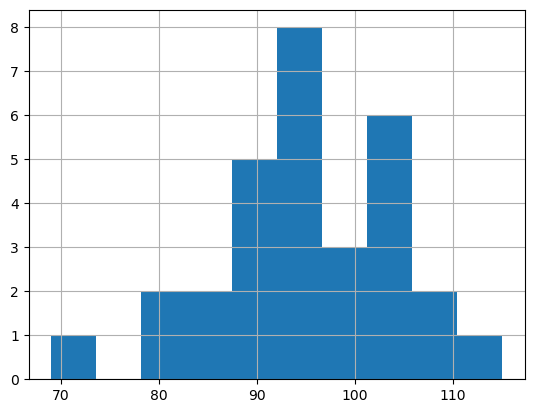

In [74]:
free_viewing_empathy = loader.load_eyeT_empathy_levels(experiment= "free")
free_viewing_empathy.hist();
free_viewing_empathy_median = free_viewing_empathy.median()

#### __Fixations__

In [70]:
free_fix_features_train, free_fix_labels_train, free_sac_features_train, free_sac_labels_train =  loader.get_eyeT_features_and_labels("train", "free")
free_fix_labels_train_class = modeler.make_labels_binary(free_fix_labels_train, free_viewing_empathy_median)
free_fix_empathy, free_fix_empathy_trace = modeler.generate_logistic_regression_model("free_fix_logistic_regression", free_fix_features_train, free_fix_labels_train_class)

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 376 seconds.


Saving model...


##### __Model diagnostics__

In [71]:
az.summary(free_fix_empathy_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-1.223,2.851,-6.291,4.367,0.051,0.043,3116.0,2522.0,1.0
beta[1],1.757,0.233,1.308,2.181,0.004,0.003,2779.0,2605.0,1.0
beta[2],9.989,2.639,5.173,15.123,0.049,0.036,2940.0,2239.0,1.0
beta[3],0.052,2.020,-3.924,3.686,0.035,0.033,3326.0,2519.0,1.0
beta[4],0.539,0.425,-0.267,1.343,0.007,0.005,4150.0,2733.0,1.0
beta[5],-7.505,1.762,-11.048,-4.374,0.032,0.024,3011.0,2331.0,1.0
beta[6],-2.542,0.872,-4.162,-0.922,0.020,0.014,1968.0,2444.0,1.0
beta[7],0.485,0.120,0.257,0.705,0.002,0.001,3760.0,2299.0,1.0
beta[8],-2.213,0.667,-3.408,-0.899,0.015,0.011,1992.0,2446.0,1.0
beta[9],3.090,0.983,1.237,4.905,0.023,0.016,1873.0,2141.0,1.0


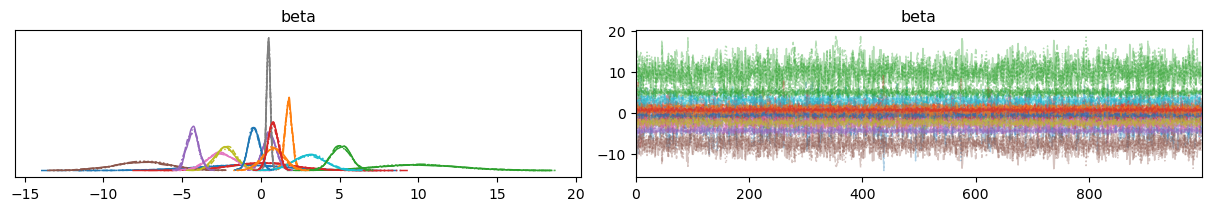

In [72]:
az.plot_trace(free_fix_empathy_trace);

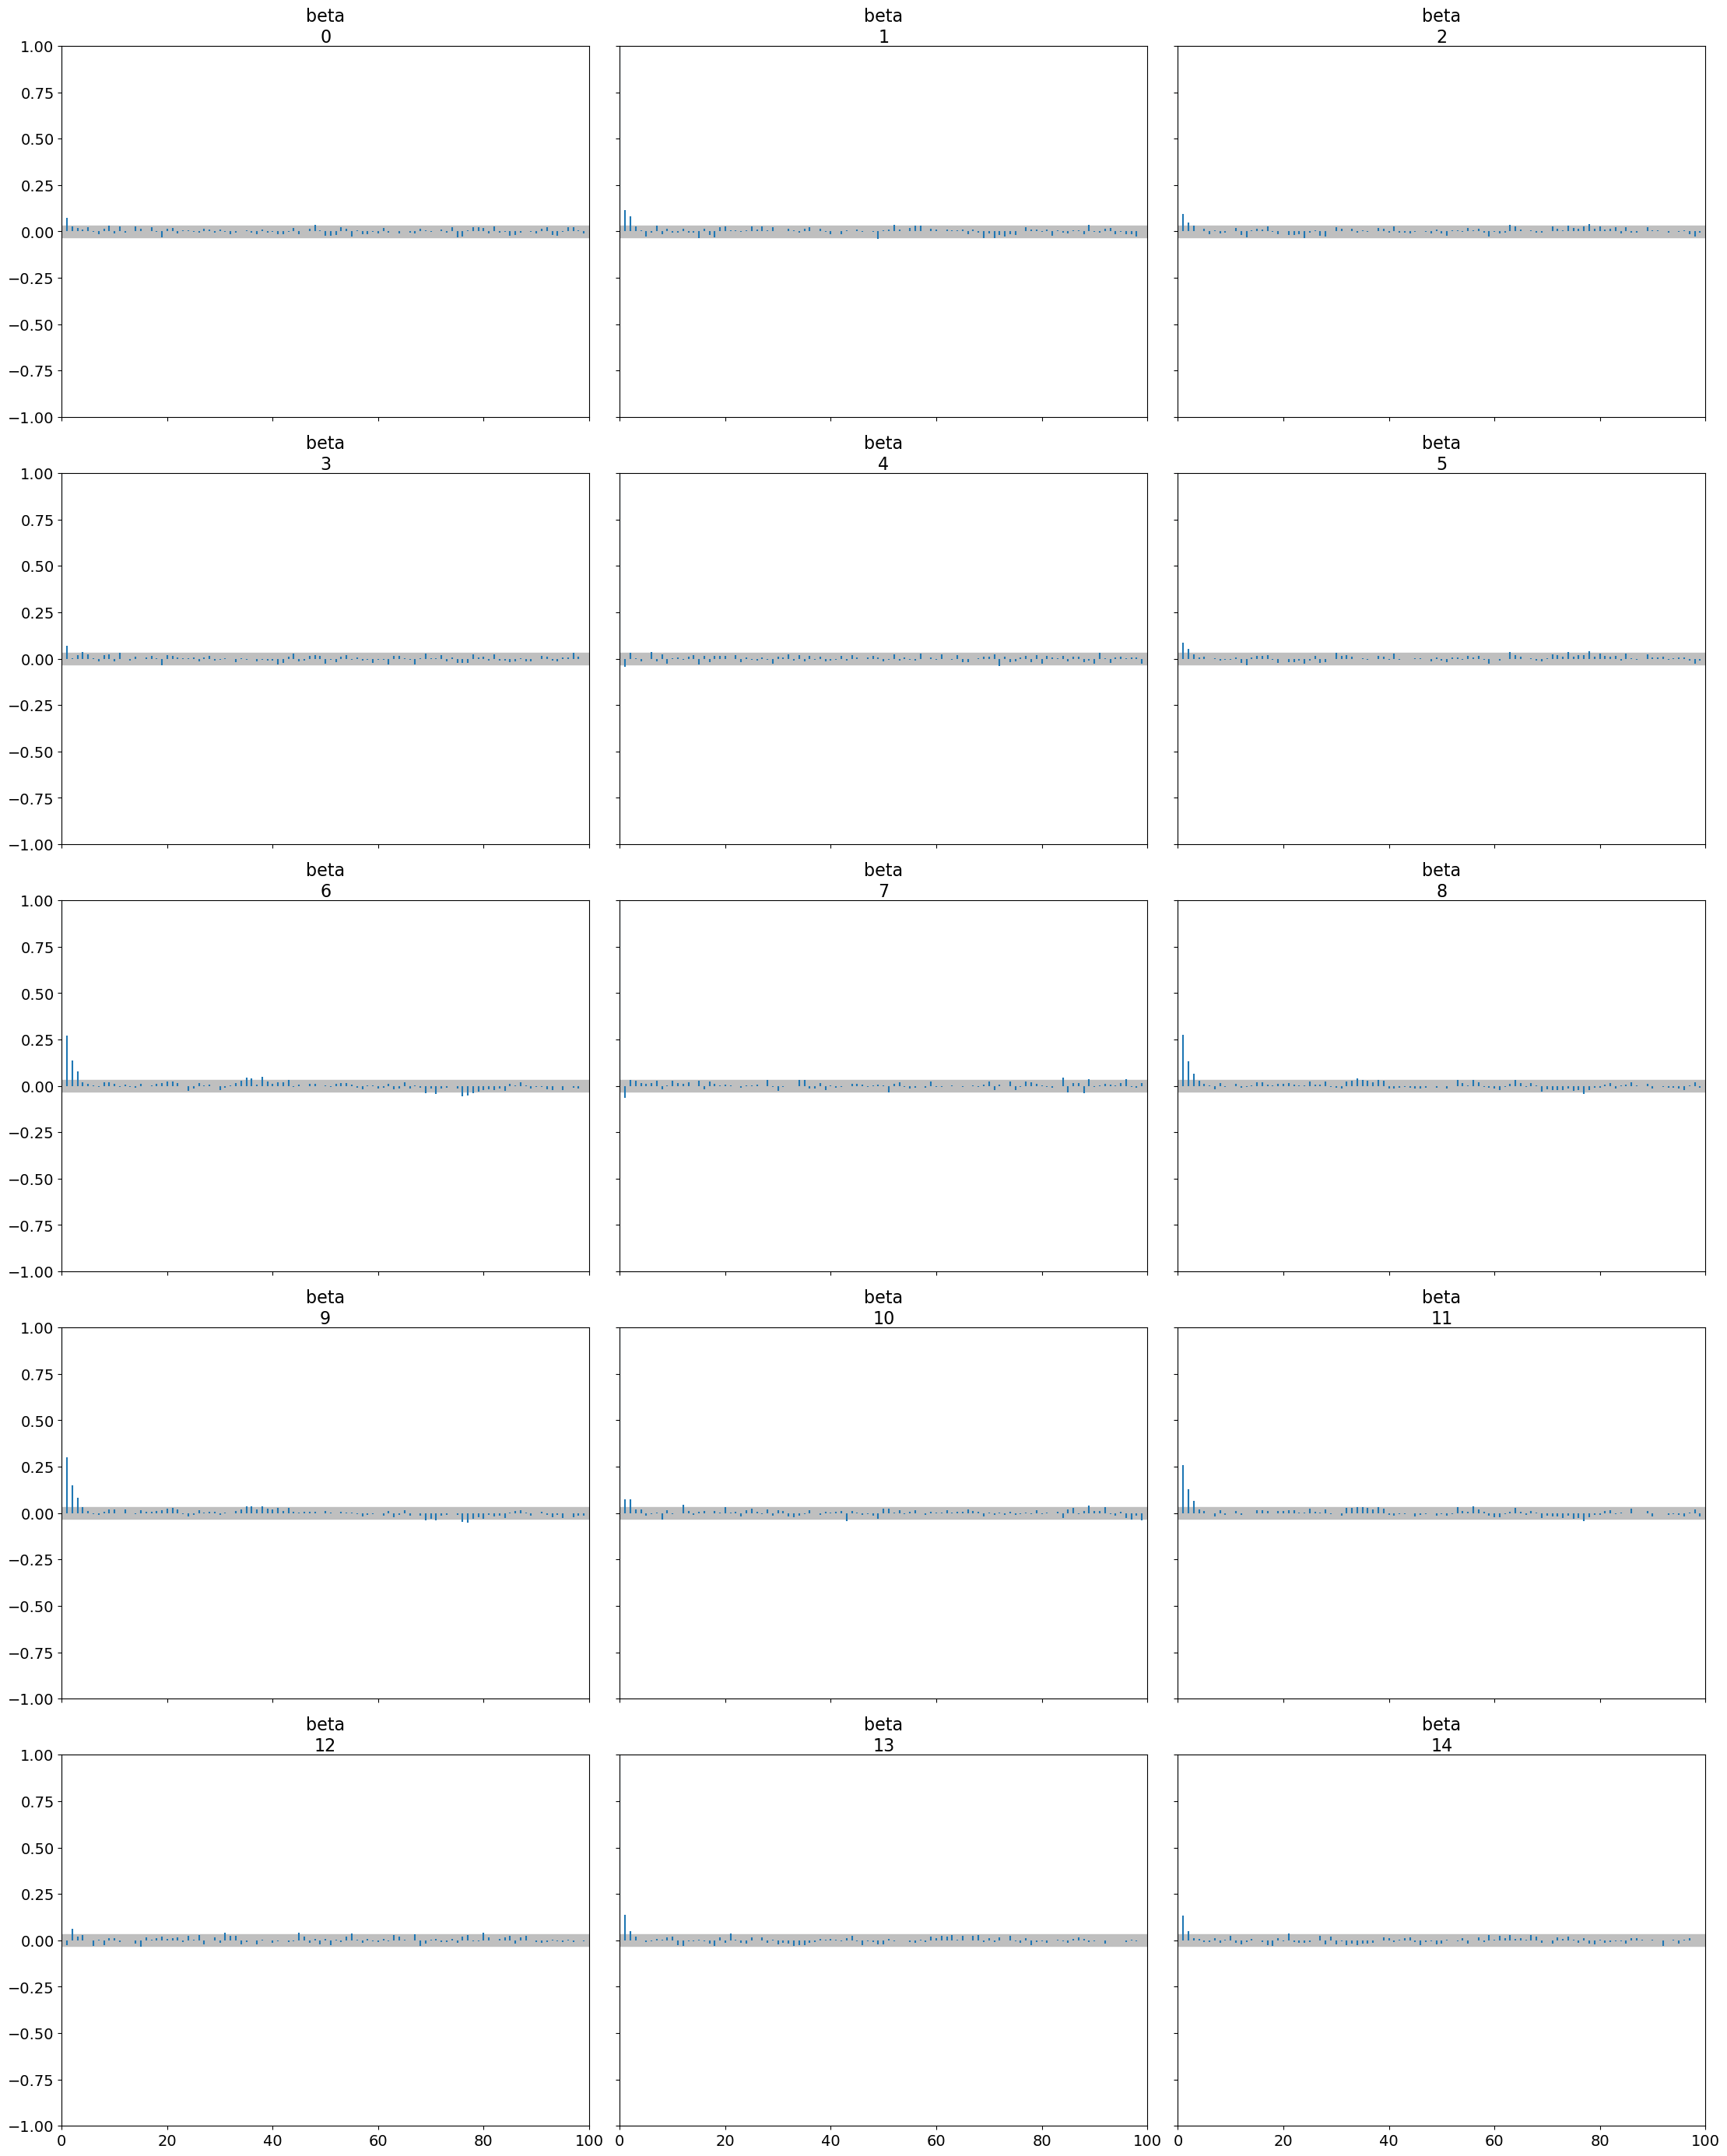

In [73]:
az.plot_autocorr(free_fix_empathy_trace, combined=True);

##### __Predictions__

In [89]:
free_fix_features_test, free_fix_labels_test, free_sac_features_test, free_sac_labels_test =  loader.get_eyeT_features_and_labels(dset="test", experiment="free")
free_fix_labels_test_class = modeler.make_labels_binary(free_fix_labels_test, free_viewing_empathy_median)
free_fix_predictions = modeler.generate_model_predictions(free_fix_empathy, free_fix_features_test, free_fix_empathy_trace)
free_fix_predictions_class = modeler.make_labels_binary(free_fix_predictions, 0.5)
accuracy_score(free_fix_labels_test_class, free_fix_predictions_class)

0.6402816300405376

#### __Saccades__

In [76]:
free_sac_labels_train_class = modeler.make_labels_binary(free_sac_labels_train, free_viewing_empathy_median)
free_sac_empathy, free_sac_empathy_trace = modeler.generate_logistic_regression_model("free_sac_logistic_regression", free_sac_features_train, free_sac_labels_train_class)

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 265 seconds.


Saving model...


##### __Model diagnostics__

In [77]:
az.summary(free_sac_empathy_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],1.274,0.622,0.147,2.477,0.012,0.009,2663.0,2785.0,1.0
beta[1],-0.061,0.163,-0.351,0.260,0.003,0.002,3305.0,3036.0,1.0
beta[2],-0.326,1.318,-2.896,1.956,0.028,0.020,2254.0,2447.0,1.0
beta[3],-0.933,0.992,-2.768,0.971,0.018,0.014,3114.0,2837.0,1.0
beta[4],-0.276,0.978,-2.073,1.592,0.017,0.014,3276.0,3030.0,1.0
beta[5],0.358,0.969,-1.329,2.238,0.019,0.014,2532.0,2752.0,1.0
beta[6],-0.098,0.478,-1.008,0.782,0.010,0.007,2414.0,2654.0,1.0
beta[7],0.152,0.083,-0.007,0.300,0.001,0.001,4325.0,3036.0,1.0
beta[8],0.509,0.424,-0.282,1.306,0.008,0.006,2736.0,2198.0,1.0
beta[9],0.155,0.648,-1.162,1.304,0.014,0.010,2273.0,2549.0,1.0


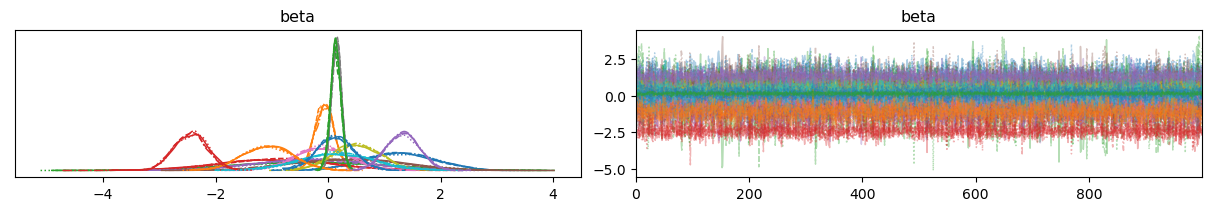

In [78]:
az.plot_trace(free_sac_empathy_trace);

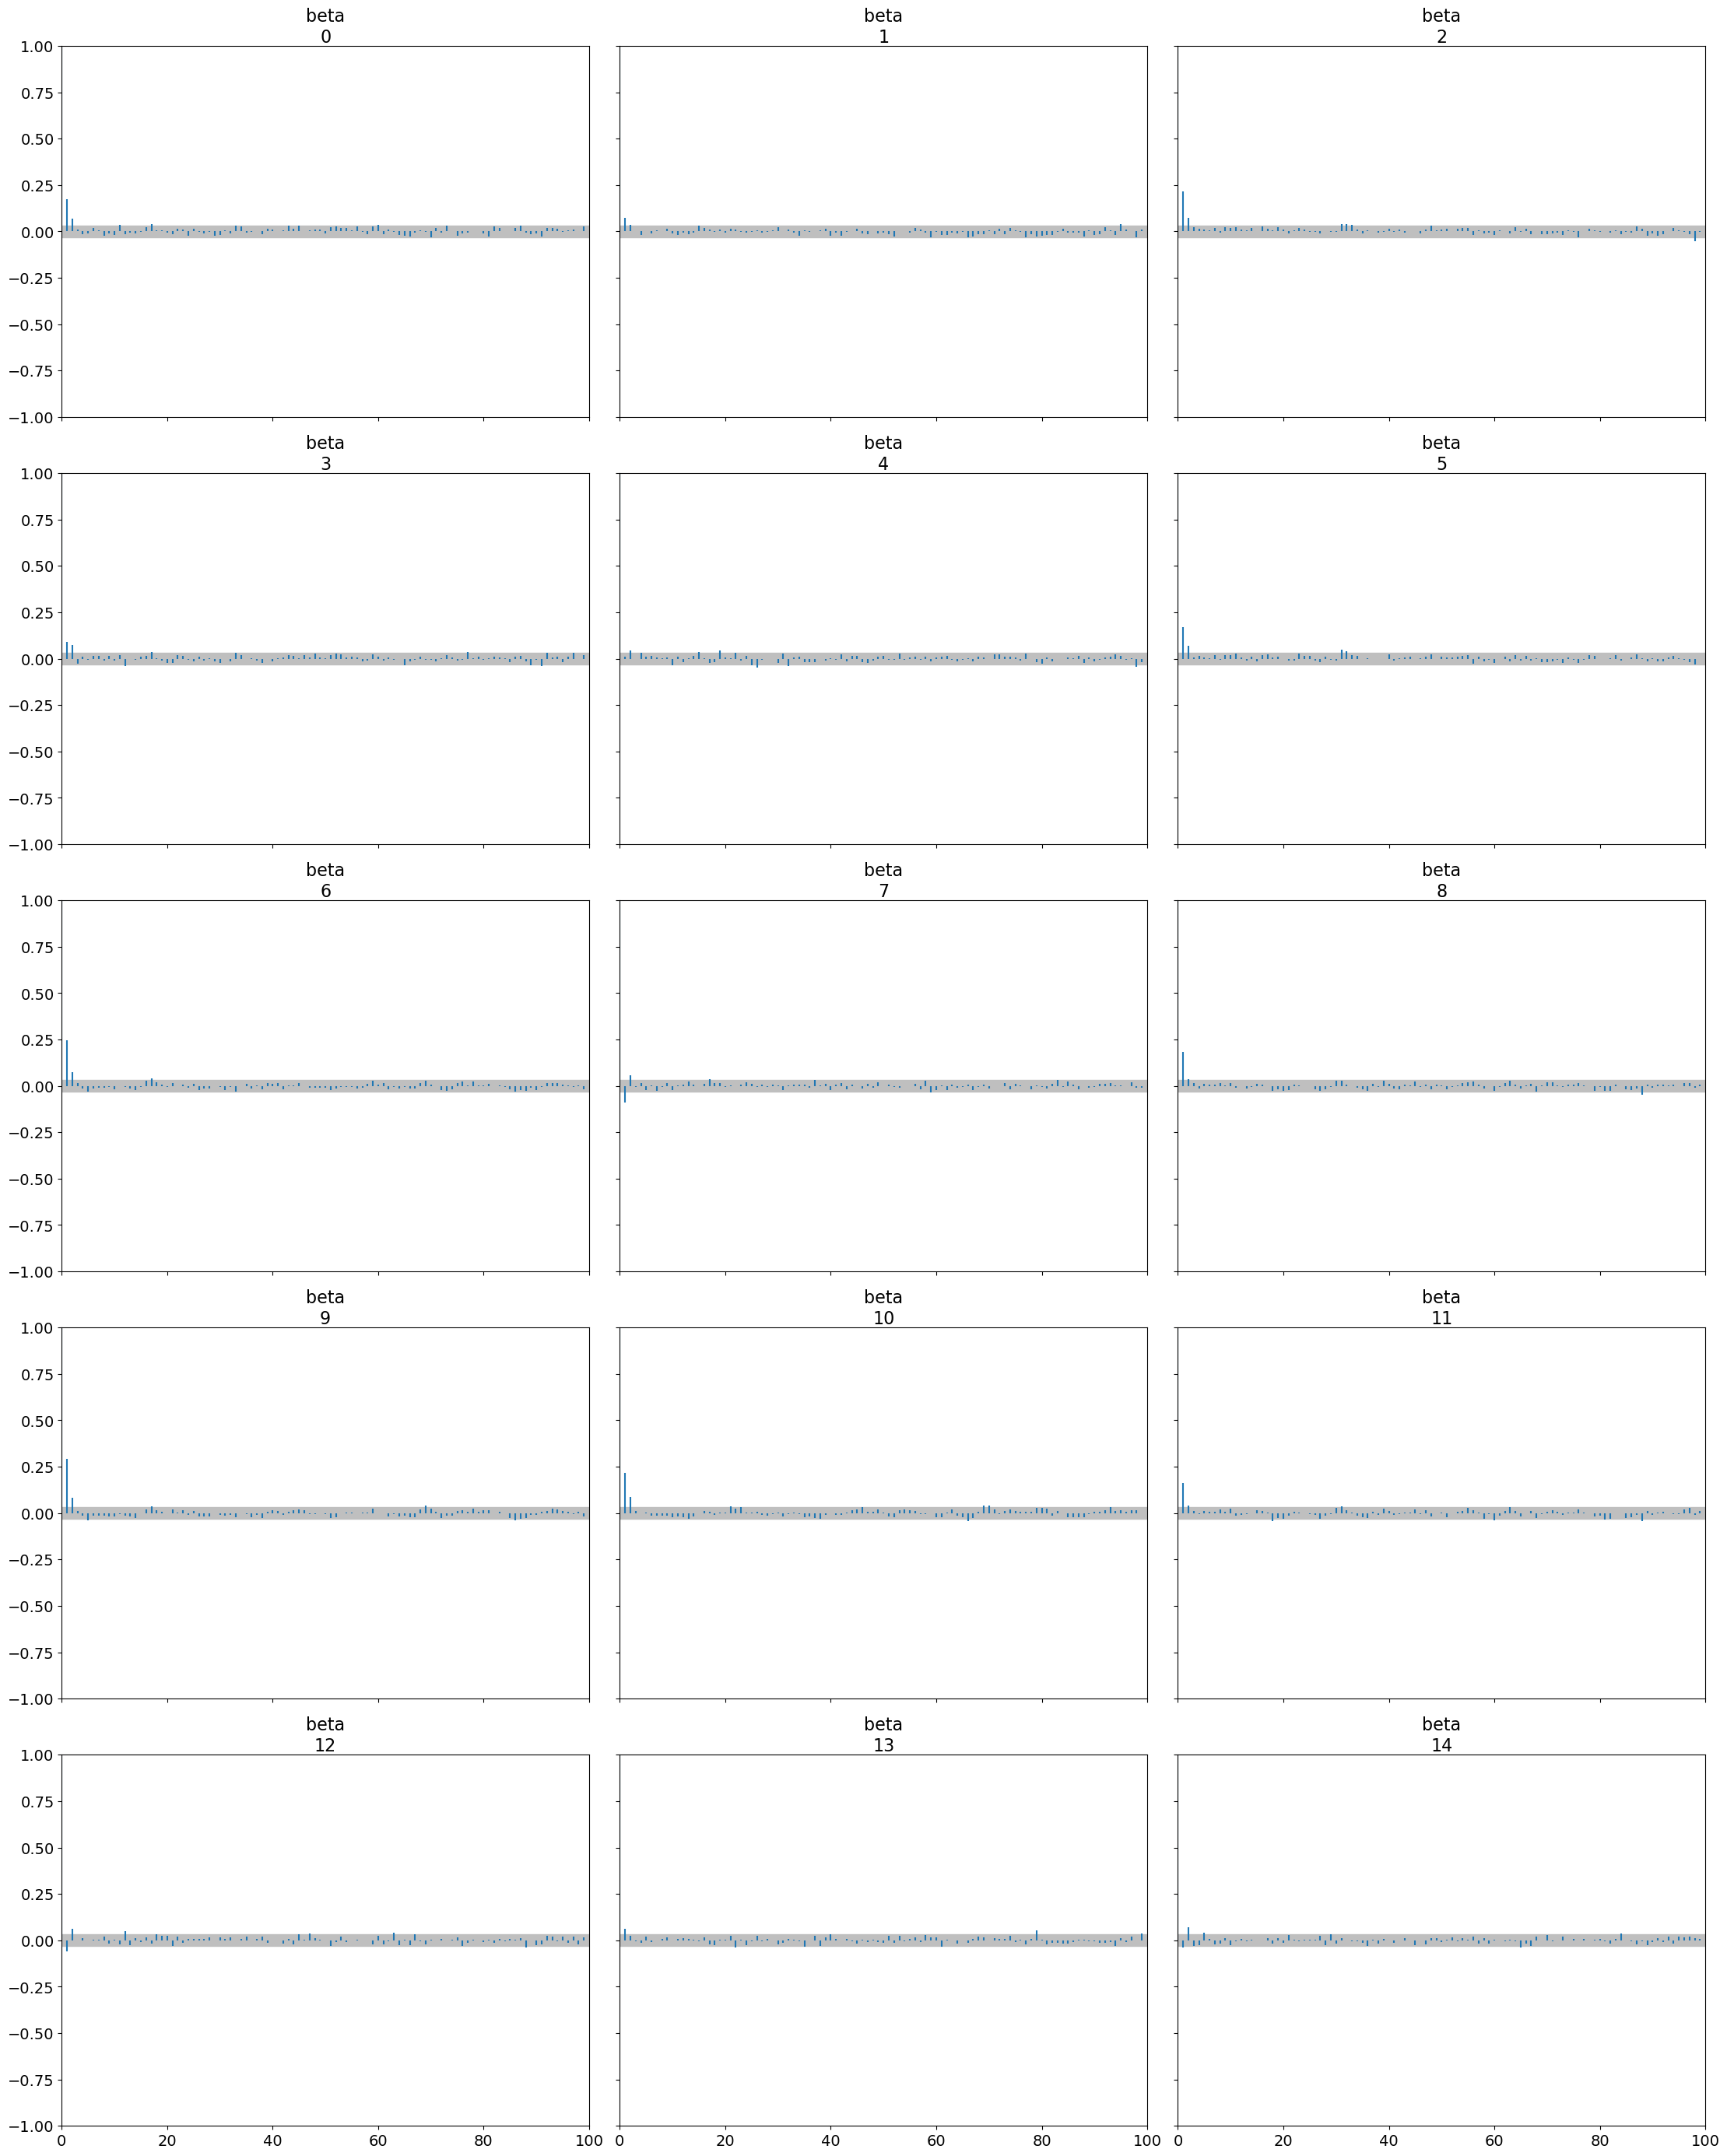

In [79]:
az.plot_autocorr(free_sac_empathy_trace, combined=True);

##### __Predictions__

In [88]:
free_sac_labels_test_class = modeler.make_labels_binary(free_sac_labels_test, free_viewing_empathy_median)
free_sac_predictions = modeler.generate_model_predictions(free_sac_empathy, free_sac_features_test, free_sac_empathy_trace)
free_sac_predictions_class = modeler.make_labels_binary(free_sac_predictions, 0.5)
accuracy_score(free_sac_labels_test_class, free_sac_predictions_class)

0.5529640427599611

#### __Combined prediction__

In [81]:
free_fix_stimuli, free_sac_stimuli = loader.get_stimuli("test", "free")

In [90]:
predicted_empathy = modeler.combine_predictions(free_fix_predictions, free_fix_stimuli, free_sac_predictions, free_sac_stimuli)
real_empathy_values = [1 if free_viewing_empathy[k[1]] >= 95 else 0 for k in predicted_empathy.keys()]
predicted_empathy_values = [1 if level >= 0.5 else 0 for level in list(predicted_empathy.values())]
accuracy_score(predicted_empathy_values, real_empathy_values)

0.6428571428571429

### __Cognitive empathy__

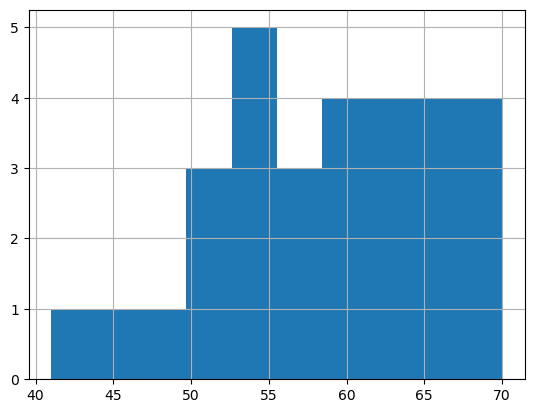

In [46]:
free_viewing_cognitive_empathy = loader.load_eyeT_empathy_levels(experiment= "free", type="cognitive")
free_viewing_cognitive_empathy.hist();
free_viewing_cognitive_empathy_median = free_viewing_cognitive_empathy.median()

#### __Fixations__

In [48]:
free_fix_cog_features_train, free_fix_cog_labels_train, free_sac_cog_features_train, free_sac_cog_labels_train =  loader.get_eyeT_features_and_labels(dset="train", type="cognitive", experiment="free")
free_fix_cog_labels_train_class = modeler.make_labels_binary(free_fix_cog_labels_train, free_viewing_cognitive_empathy_median)
free_fix_cog_empathy, free_fix_cog_trace = modeler.generate_logistic_regression_model("free_fix_cognitive_logistic_regression", free_fix_cog_features_train, free_fix_cog_labels_train_class)

##### __Sampling diagnostics__

In [17]:
az.summary(free_fix_cog_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],1.900,3.033,-3.572,7.850,0.056,0.045,2996.0,2845.0,1.0
beta[1],-3.277,0.244,-3.746,-2.825,0.005,0.003,2812.0,3103.0,1.0
beta[2],8.457,2.848,3.105,13.840,0.052,0.039,3021.0,2430.0,1.0
beta[3],-0.628,2.232,-4.873,3.410,0.046,0.034,2481.0,2630.0,1.0
beta[4],-0.744,0.449,-1.563,0.122,0.007,0.005,4663.0,3120.0,1.0
beta[5],-5.577,1.869,-9.152,-2.093,0.034,0.025,3089.0,2460.0,1.0
beta[6],-0.838,0.924,-2.610,0.864,0.020,0.014,2076.0,2488.0,1.0
beta[7],0.013,0.128,-0.230,0.249,0.002,0.002,4619.0,3136.0,1.0
beta[8],-4.122,0.756,-5.538,-2.721,0.017,0.012,2069.0,2597.0,1.0
beta[9],-0.122,1.021,-2.052,1.779,0.023,0.016,2015.0,2462.0,1.0


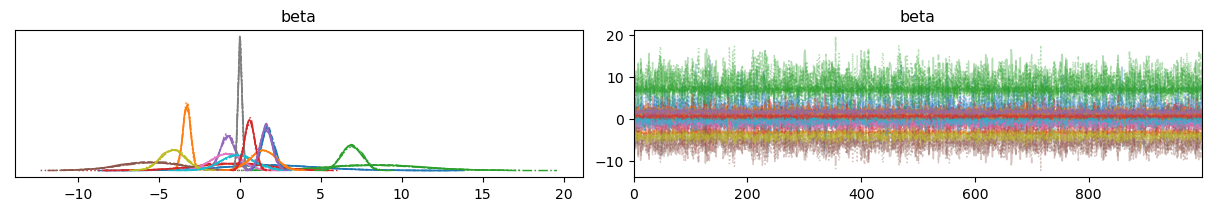

In [19]:
az.plot_trace(free_fix_cog_trace);

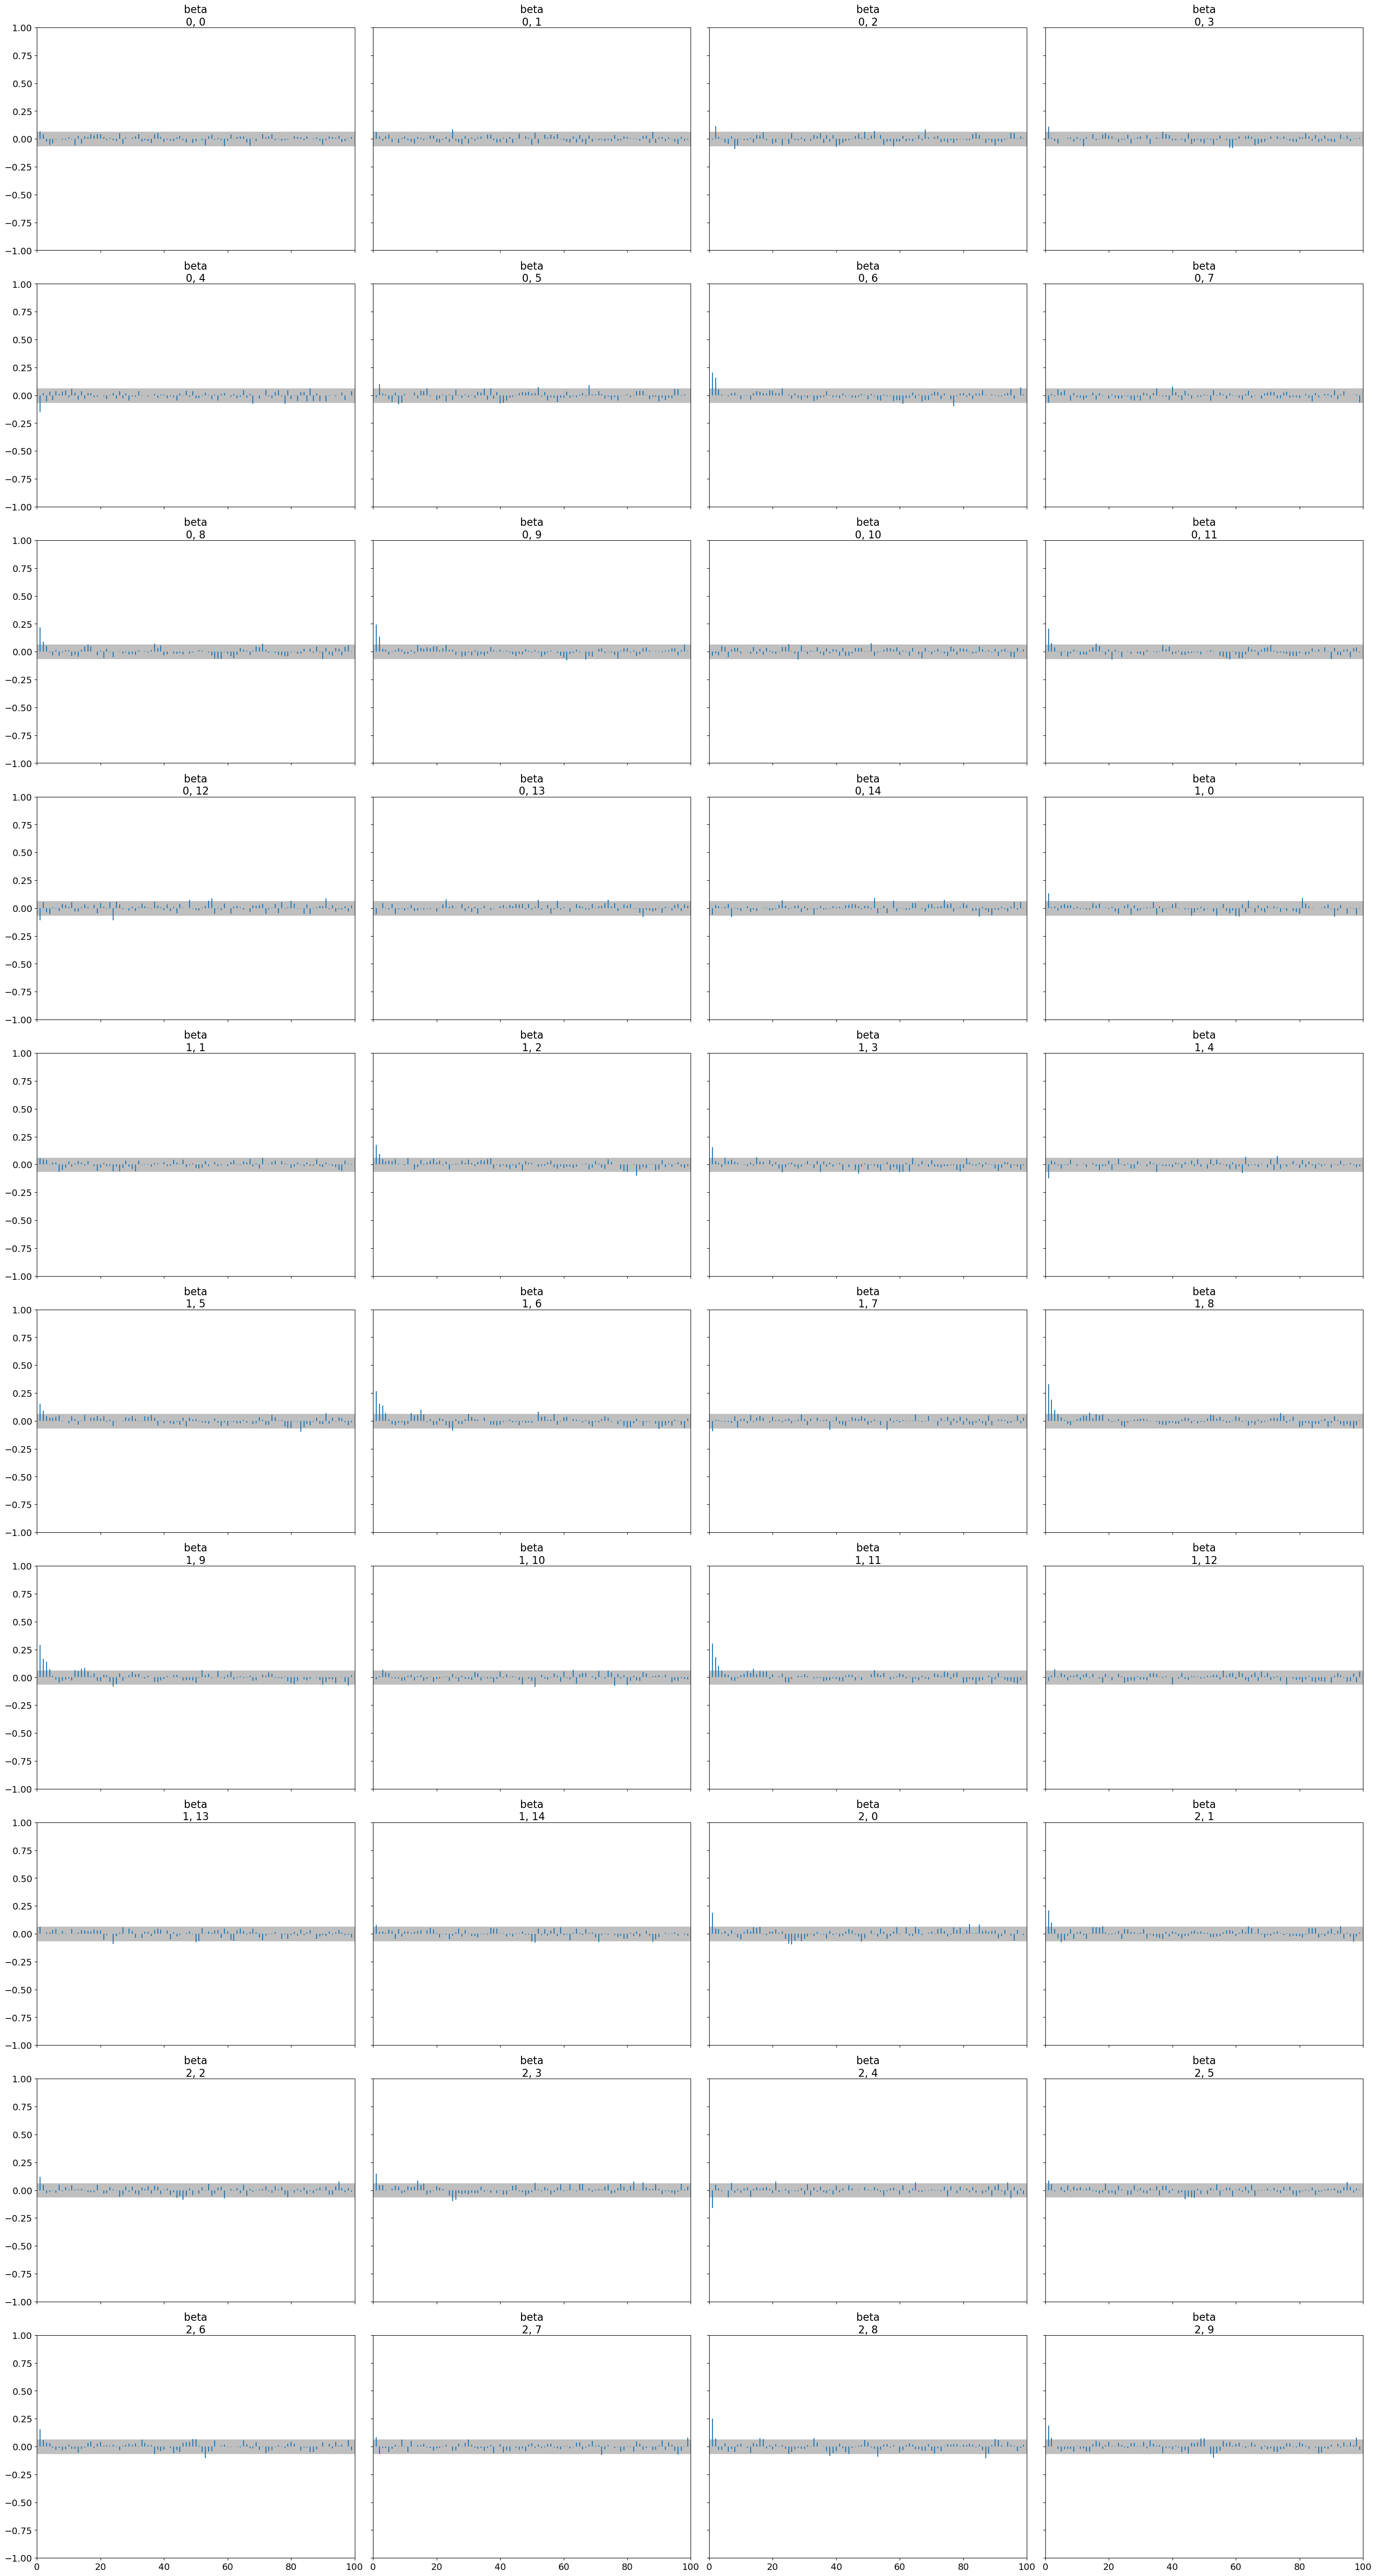

In [20]:
az.plot_autocorr(free_fix_cog_trace);

##### __Predictions__

In [92]:
free_fix_cog_features_test, free_fix_cog_labels_test, free_sac_cog_features_test, free_sac_cog_labels_test =  loader.get_eyeT_features_and_labels(dset="test", type="cognitive", experiment="free")
free_fix_cog_labels_test_class = modeler.make_labels_binary(free_fix_cog_labels_test, free_viewing_cognitive_empathy_median)
free_fix_cog_predictions = modeler.generate_model_predictions(free_fix_cog_empathy, free_fix_cog_features_test, free_fix_cog_trace)
free_fix_cog_predictions_class = modeler.make_labels_binary(free_fix_cog_predictions, 0.5)
accuracy_score(free_fix_cog_labels_test_class, free_fix_cog_predictions_class)

0.5852357584809046

#### __Saccades__

In [50]:
free_sac_cog_labels_train_class = modeler.make_labels_binary(free_sac_cog_labels_train, free_viewing_cognitive_empathy_median)
free_sac_cog_empathy, free_sac_cog_trace = modeler.generate_logistic_regression_model("free_sac_cognitive_logistic_regression", free_sac_cog_features_train, free_sac_cog_labels_train_class)

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 304 seconds.


Saving model...


##### __Sampling diagnostics__

In [51]:
az.summary(free_sac_cog_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],1.339,0.634,0.182,2.487,0.012,0.009,2589.0,2540.0,1.0
beta[1],-0.500,0.162,-0.809,-0.204,0.003,0.002,2585.0,2703.0,1.0
beta[2],-2.206,1.378,-4.657,0.419,0.030,0.021,2150.0,2457.0,1.0
beta[3],-2.893,1.085,-4.928,-0.904,0.020,0.014,3089.0,2992.0,1.0
beta[4],0.424,1.014,-1.422,2.301,0.019,0.014,2835.0,2965.0,1.0
beta[5],1.906,1.002,0.123,3.827,0.021,0.015,2389.0,2875.0,1.0
beta[6],-0.037,0.493,-0.933,0.933,0.010,0.007,2381.0,2834.0,1.0
beta[7],0.120,0.086,-0.047,0.278,0.001,0.001,4446.0,3130.0,1.0
beta[8],-0.174,0.428,-0.965,0.615,0.008,0.006,2593.0,2692.0,1.0
beta[9],-1.212,0.678,-2.576,-0.033,0.015,0.010,2164.0,2517.0,1.0


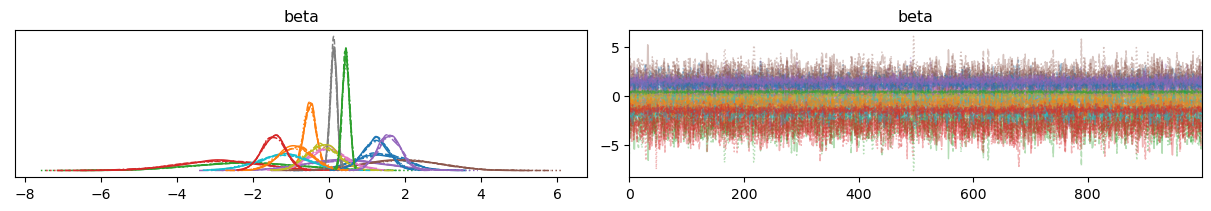

In [52]:
az.plot_trace(free_sac_cog_trace);

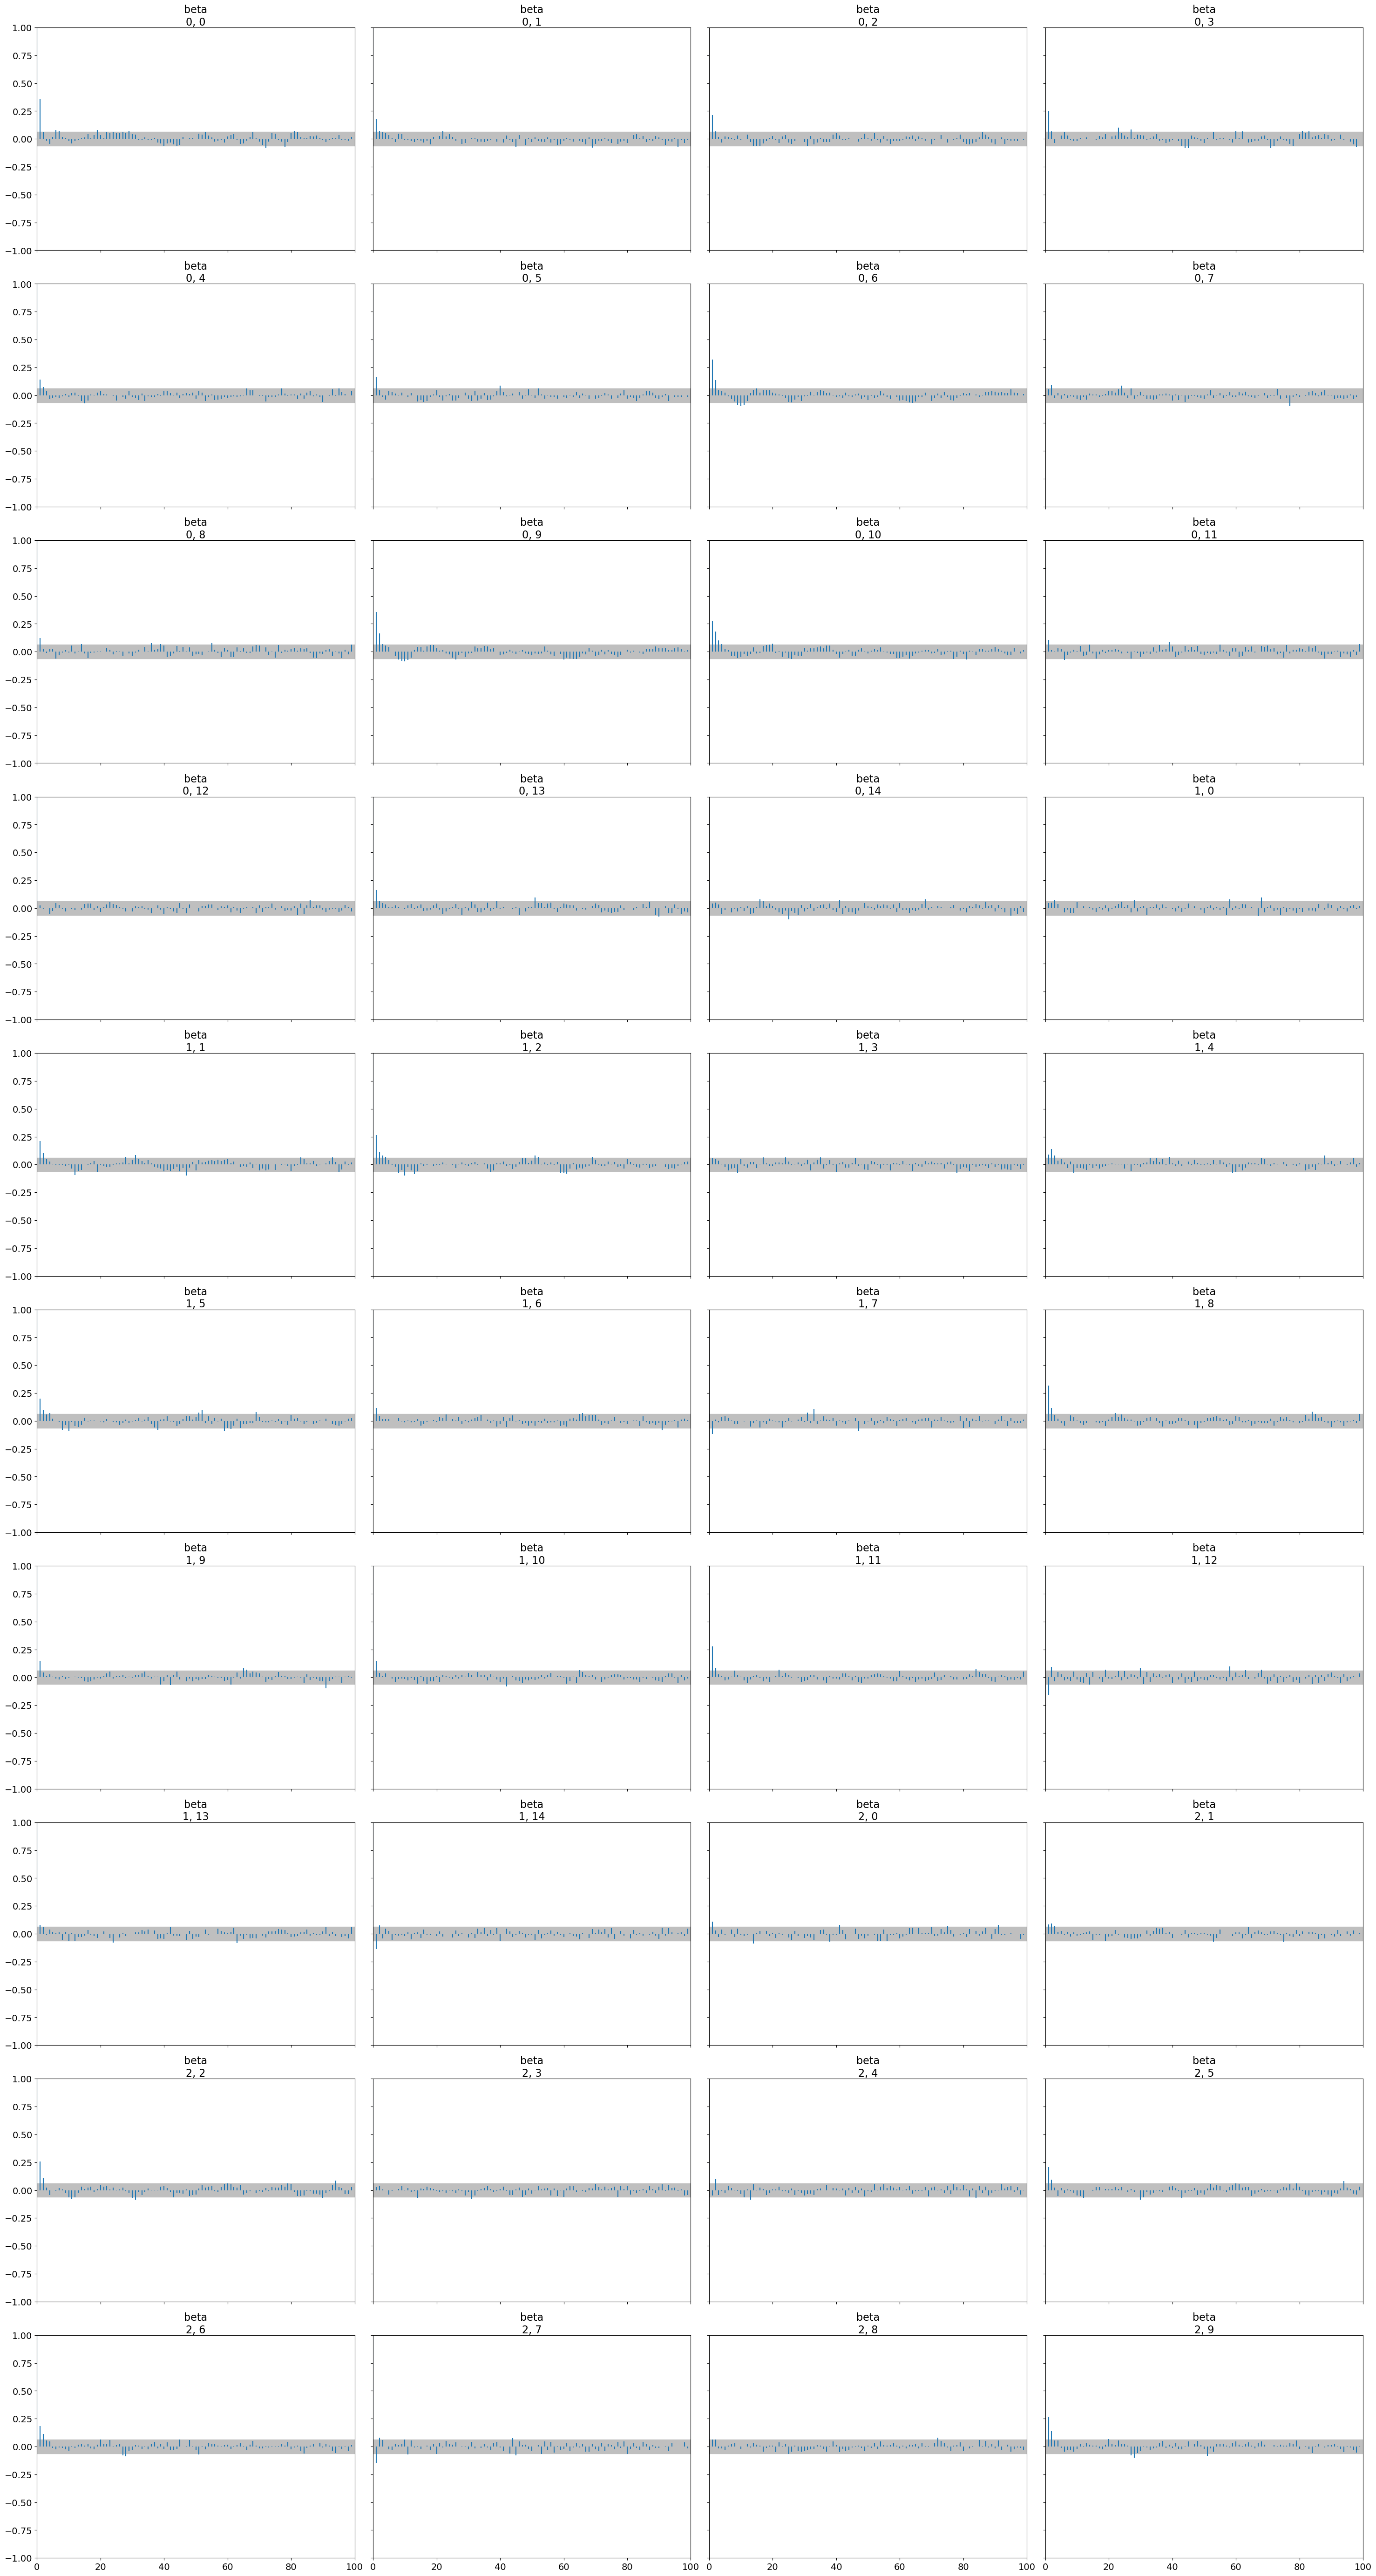

In [53]:
az.plot_autocorr(free_sac_cog_trace);

##### __Predictions__

In [93]:
free_sac_cog_labels_test_class = modeler.make_labels_binary(free_sac_cog_labels_test, free_viewing_cognitive_empathy_median)
free_sac_cog_predictions = modeler.generate_model_predictions(free_sac_cog_empathy, free_sac_cog_features_test, free_sac_cog_trace)
free_sac_cog_predictions_class = modeler.make_labels_binary(free_sac_cog_predictions, 0.5)
accuracy_score(free_sac_cog_labels_test_class, free_sac_cog_predictions_class)

0.6248785228377065

#### __Combined predictions__

In [57]:
free_fix_stimuli, free_sac_stimuli = loader.get_stimuli("test", "free")

In [95]:
predicted_cog_empathy = modeler.combine_predictions(free_fix_cog_predictions, free_fix_stimuli, free_sac_cog_predictions, free_sac_stimuli)
real_empathy_cog_values = [1 if free_viewing_cognitive_empathy[k[1]] >= free_viewing_cognitive_empathy_median else 0 for k in predicted_cog_empathy.keys()]
predicted_empathy_cog_values = [1 if level >= 0.5 else 0 for level in list(predicted_cog_empathy.values())]
accuracy_score(predicted_empathy_cog_values, real_empathy_cog_values)

0.5892857142857143